Baseline text:
* latin letters + numbers
* random inclination between -1/+1 degrees
* up to 5 separated "words"
* random gaussian blur between -1/+1 radius

Tests performed: 
1. `trdg -c 500 -na 2 -rs -num -let -t 4 -f 64 -w 5 -r -b 1 -tc '#000000' -bl 1 -rbl -k 1 -rk -m 10,10,10,10 --output_dir 1` 
2. `trdg -c 500 -na 2 -rs -num -let -t 4 -f 64 -w 5 -r -b 1 -tc '#000000' -bl 1 -rbl -k 1 -rk --output_dir 2`
3. `trdg -c 500 -na 2 -rs -num -let -t 4 -f 32 -w 5 -r -b 1 -tc '#000000' -bl 1 -rbl -k 1 -rk --output_dir 3`
4. `trdg -c 500 -na 2 -rs -num -let -t 4 -f 32 -w 5 -r -b 0 -tc '#000000' -bl 1 -rbl -k 1 -rk --output_dir 4`
5. `trdg -c 500 -na 2 -rs -num -let -t 4 -f 32 -w 5 -r -b 0 -tc '#000000,#2B21C8' -bl 1 -rbl -k 1 -rk --output_dir 5`
6. `trdg -c 500 -na 2 -rs -num -let -t 4 -f 32 -w 5 -r -b 0 -tc '#000000,#2B21C8' -bl 1 -rbl -k 1 -rk -d 3 --output_dir 6`

In [4]:
tests = {
    "1": "1. white back + black text + 10px margin (big) + 64px res",
    "2": "2. white back + black text + small margin + 64px res",
    "3": "3. white back + black text + small margin + 32px res",
    "4": "4. noise back + black text + small margin + 32px res",
    "5": "5. noise back + black/blue text + small margin + 32px res",
    "6": "6. noise back + black/blue text + small margin + 32px res + distorted text",
}
direc = "6"
what = tests[direc]

In [10]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'
import easyocr
from PIL import Image
import boto3
import io
import pandas as pd
from Levenshtein import distance
from tqdm.notebook import tqdm
tqdm.pandas()

import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np

reader = easyocr.Reader(['en'], gpu = False)
textract = boto3.client('textract')

def image_to_byte_array(image: Image):
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format=image.format)
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr

def aws_textract_read(path):
    img = Image.open(path)
    response = textract.detect_document_text(Document={'Bytes': image_to_byte_array(img)})

    text = " "
    for block in response["Blocks"]:
        if block["BlockType"] == "LINE":
            text+=(block["Text"]+" ")
    return text.strip()

def easy_ocr_read(path):
    text = reader.readtext(path, detail = 0)
    if len(text) > 0:
        return text[0]
    else:
        return ""

def pytesseract_read(path):
    text = pytesseract.image_to_string(Image.open(path))
    text = text.replace("\n\x0c", "")
    text = text.replace("\n", "")
    text = text.replace("\\x", "")
    return text

/Users/francescopochetti/miniconda3/envs/ocr/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
Using CPU. Note: This module is much faster with a GPU.


In [5]:
df = pd.read_csv("./"+direc+"/labels.txt", sep=".jpg ", names=["filename", "sentence"])
df.filename = "./"+direc+"/" + df.filename.astype(str) + ".jpg"
df.sentence = df.sentence.str.strip()
print(df.shape)
df.head()

(500, 2)


/Users/francescopochetti/miniconda3/envs/ocr/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,filename,sentence
0,./6/0.jpg,VLa
1,./6/1.jpg,3QYw
2,./6/2.jpg,S0 zv TZCnBt0W NzNnoxXT3
3,./6/3.jpg,J1KF7U HNuR ek0KBDqP 0oKw0dkJ
4,./6/4.jpg,itN IzBsI CYHFpdtVR


In [4]:
df["easyocr"] = df.filename.progress_apply(lambda x: easy_ocr_read(x))
df["tesseract"] = df.filename.progress_apply(lambda x: pytesseract_read(x))
df["textract"] = df.filename.progress_apply(lambda x: aws_textract_read(x))

  0%|          | 0/500 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/ocr/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [5]:
df["easyocr_score"] = df.apply(lambda row: distance(row["sentence"], row["easyocr"]), axis=1)
df["tesseract_score"] = df.apply(lambda row: distance(row["sentence"], row["tesseract"]), axis=1)
df["textract_score"] = df.apply(lambda row: distance(row["sentence"], row["textract"]), axis=1)

In [8]:
df["what"] = what
df.to_csv("./"+direc+"/df.csv", index=False)

In [11]:
dfs = ["./"+str(i)+"/df.csv" for i in range(1, 7)]
dfs = [pd.read_csv(i) for i in dfs]

big = pd.concat(dfs)
big.head()

,filename,sentence,easyocr,tesseract,textract,easyocr_score,tesseract_score,textract_score,what
0,./1/0.jpg,Aw vmP 2zQ5O G3iO4VAi,@u unG g2Qs0,Q. um@® 22Qs0 G3iO Qi,am ump 2ZQ50 GsiOnkai,18,11,10,1. white back + black text + 10px margin (big)...
1,./1/1.jpg,QGwmKGmEkU wvuJkiLN m0V g1iT8jt0H 3rvsNa,QGwmK GmEkU wvuJkiLN mOV gliT8jtOH 3rvsNa,QGwmKGmEkKU wvuJkiLN mOV g1iT8jtOH 3rvsNa,QGwmK GmEkU wvulkiLN mOV g1iT8jtOH 3rvsNa,4,3,4,1. white back + black text + 10px margin (big)...
2,./1/2.jpg,yFHgJVKc8,YFHgJVKc8,yFHgJVKc8,yFHgJVKc8,1,0,0,1. white back + black text + 10px margin (big)...
3,./1/3.jpg,6PfdhEtBFc aaTj l1kfRA sasHKkm 74t,6Pf dhEtBFc aaTj I1kf RA sasHKkm 74t,6Pf dhEtBFc aaTj I1kf RA sasHKkm 74t,6Pf dhEtBFc aaTj l1kf RA sasHKkm 74t,3,3,2,1. white back + black text + 10px margin (big)...
4,./1/4.jpg,MG siF8VgUjij jgfKWc wwMo77CUSr,MG SIF8 VGUJIJ JGFK WC WWMOTTCUSR,MG SIESVGUI JGEK WC WWMOT77CUSR,MG SIF8VGUJU IGFKWC WWMOT7CUSR,18,18,15,1. white back + black text + 10px margin (big)...


In [12]:
big.iloc[0]

filename                                                   ./1/0.jpg
sentence                                       Aw vmP 2zQ5O G3iO4VAi
easyocr                                                 @u unG g2Qs0
tesseract                                      Q. um@® 22Qs0 G3iO Qi
textract                                       am ump 2ZQ50 GsiOnkai
easyocr_score                                                     18
tesseract_score                                                   11
textract_score                                                    10
what               1. white back + black text + 10px margin (big)...
Name: 0, dtype: object

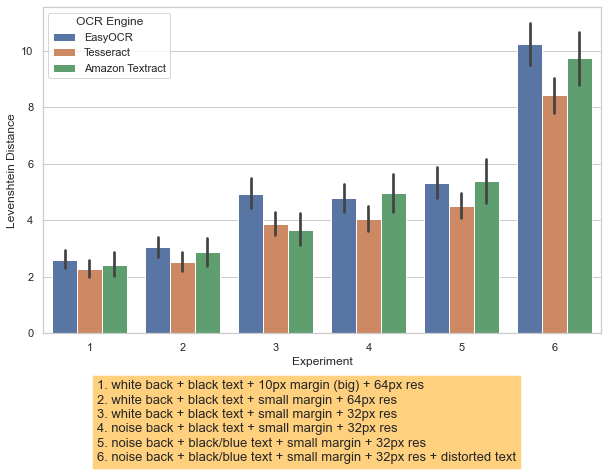

In [84]:
d = big[["easyocr_score", "tesseract_score", "textract_score"]].stack().reset_index()
d["experiment"] = sorted(np.arange(1, 7).tolist() * 1500)
d.drop("level_0", axis=1, inplace=True)
d.columns = ["OCR Engine", "Levenshtein Distance", "Experiment"]
d['OCR Engine'] = d['OCR Engine'].map({"easyocr_score": "EasyOCR", "tesseract_score": "Tesseract", "textract_score": "Amazon Textract"})

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x="Experiment", y="Levenshtein Distance", hue="OCR Engine", data=d, ax=ax)
plt.figtext(0.2, -.17, "\n".join(big.what.unique().tolist()), ha="left", fontsize=13, bbox={"facecolor":"orange", "alpha":0.5, "pad":5});

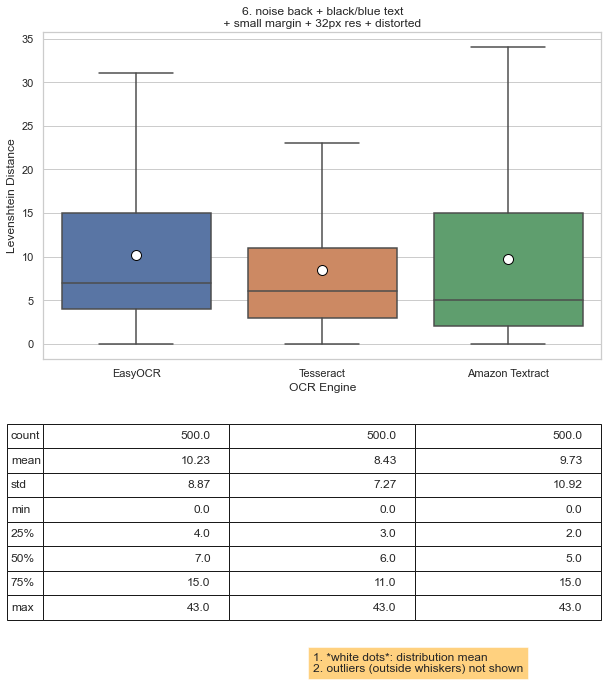

In [82]:
import matplotlib.pyplot as plt

def plot_df(df, experiment=None):
    if experiment is None:
        scores = df.easyocr_score.append(df.tesseract_score).append(df.textract_score)
        n = 3000
        title = "All experiments combined"
    else:
        df = df.loc[df.what.str.startswith(experiment)]
        scores = df.easyocr_score.append(df.tesseract_score).append(df.textract_score)
        n = 500
        assert len(df) == n
        title = df.what.unique()[0].split("text")
        title = title[0] + "text\n" + title[1]
        
    labels = (["EasyOCR"] * n) + (["Tesseract"] * n) + (["Amazon Textract"] * n)
    temp = pd.DataFrame({"Levenshtein Distance": scores, "OCR Engine": labels})
    table = df[["easyocr_score", "tesseract_score", "textract_score"]].describe()

    ax = sns.boxplot(x="OCR Engine", y="Levenshtein Distance", data=temp, 
                     showfliers=False, showmeans=True,
                     meanprops={"marker":"o",
                                "markerfacecolor":"white", 
                                "markeredgecolor":"black",
                                "markersize":"10"})
    ax.set_title(title)
    ax.table(cellText=np.round(table.values, 2), rowLabels=table.index, loc='bottom', bbox=[0, -0.8, 1, 0.6])
    plt.figtext(0.5, -.6, "1. *white dots*: distribution mean\n2. outliers (outside whiskers) not shown", ha="left", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    return ax


_ = plot_df(big, "6.")

In [60]:
import time

cpu_reader = easyocr.Reader(['en'], gpu = False)
gpu_reader = easyocr.Reader(['en'], gpu = True)

df = pd.read_csv("./1/labels.txt", sep=".jpg ", names=["filename", "sentence"])
df.filename = "./1/" + df.filename.astype(str) + ".jpg"
df.sentence = df.sentence.str.strip()

def easyocr_time(path, reader): reader.readtext(path, detail = 0)
def tesseract_time(path): pytesseract.image_to_string(Image.open(path))

def crono(what, df):
    start = time.time()

    if what == "Tesseract":
        _ = [tesseract_time(filename) for filename in df.filename]
    elif what == "EasyOCR CPU":
        _ = [easyocr_time(filename, cpu_reader) for filename in df.filename]
    elif what == "EasyOCR GPU":
        _ = [easyocr_time(filename, gpu_reader) for filename in df.filename]
    
    ocr_time = time.time() - start
    print(f"{what}: processed {len(df)} images in {ocr_time:.4f}s, at ({len(df) / ocr_time:.2f} FPS).")

crono("Tesseract", df)
crono("EasyOCR CPU", df)
crono("EasyOCR GPU", df)

Using CPU. Note: This module is much faster with a GPU.


Tesseract: processed 500 images in 131.6549s, at (3.80 FPS).


/home/ubuntu/anaconda3/envs/ocr/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EasyOCR CPU: processed 500 images in 71.4887s, at (6.99 FPS).
EasyOCR GPU: processed 500 images in 17.3699s, at (28.79 FPS).


In [7]:
from Levenshtein import distance
a, b = "aaa", "aaa"
print(f"Levenshtein distance between '{a}' and '{b}': {distance(a, b)}")

a, b = "aaa", "aaaa"
print(f"Levenshtein distance between '{a}' and '{b}': {distance(a, b)}")

a, b = "aaa", "aab"
print(f"Levenshtein distance between '{a}' and '{b}': {distance(a, b)}")

a, b = "bba", "aaa"
print(f"Levenshtein distance between '{a}' and '{b}': {distance(a, b)}")

a, b = "bbb", "aaa"
print(f"Levenshtein distance between '{a}' and '{b}': {distance(a, b)}")

a, b = "bbbb", "aaa"
print(f"Levenshtein distance between '{a}' and '{b}': {distance(a, b)}")

Levenshtein distance between 'aaa' and 'aaa': 0
Levenshtein distance between 'aaa' and 'aaaa': 1
Levenshtein distance between 'aaa' and 'aab': 1
Levenshtein distance between 'bba' and 'aaa': 2
Levenshtein distance between 'bbb' and 'aaa': 3
Levenshtein distance between 'bbbb' and 'aaa': 4
